# Multi-Omics Analysis for CRC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import random
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
from coxae.baselines.maui import MauiClustering
from coxae.datasets import download_maui_data
from coxae.preprocessing import maui_scale
from coxae.utils import get_kmfs

In [3]:
# Set the random seeds
seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Data visualisation

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [5]:
data_directory = "./data/maui_data"

In [6]:
download_maui_data(data_directory)

In [7]:
survival = pd.read_csv(os.path.join(data_directory, 'survival.csv'), index_col=0)
survival.head()

,duration,observed,gender,age,stage
bcr_patient_barcode,,,,,
TCGA-3L-AA1B,154,False,0,61.312329,1.0
TCGA-4N-A93T,8,False,1,67.186301,3.0
TCGA-4T-AA8H,160,False,0,42.449315,2.0
TCGA-5M-AAT4,49,True,1,74.232877,4.0
TCGA-5M-AAT6,290,True,0,40.690411,4.0


In [8]:
subtypes = pd.read_csv(os.path.join(data_directory, 'subtypes.csv'), index_col=0)
subtypes.head()

,dataset,age,gender,stage,pt,pn,pm,tnm,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
sample,,,,,,,,,,,,,,,,,,
TCGA-A6-2670,tcga,45.0,male,2.0,3.0,0.0,0.0,IIA,NaN,NaN,CIMP.Neg,0.0,0.0,CMS4,13.906849,0.0,NaN,NaN
TCGA-A6-2671,tcga,85.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,21.304110,0.0,NaN,NaN
TCGA-A6-2672,tcga,82.0,female,3.0,3.0,1.0,0.0,IIIB,NaN,msi,CIMP.High,0.0,0.0,CMS1,16.536986,0.0,NaN,NaN
TCGA-A6-2674,tcga,71.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,17.194521,0.0,NaN,NaN
TCGA-A6-2675,tcga,78.0,male,2.0,3.0,0.0,NaN,IIA,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,16.931507,0.0,NaN,NaN


Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

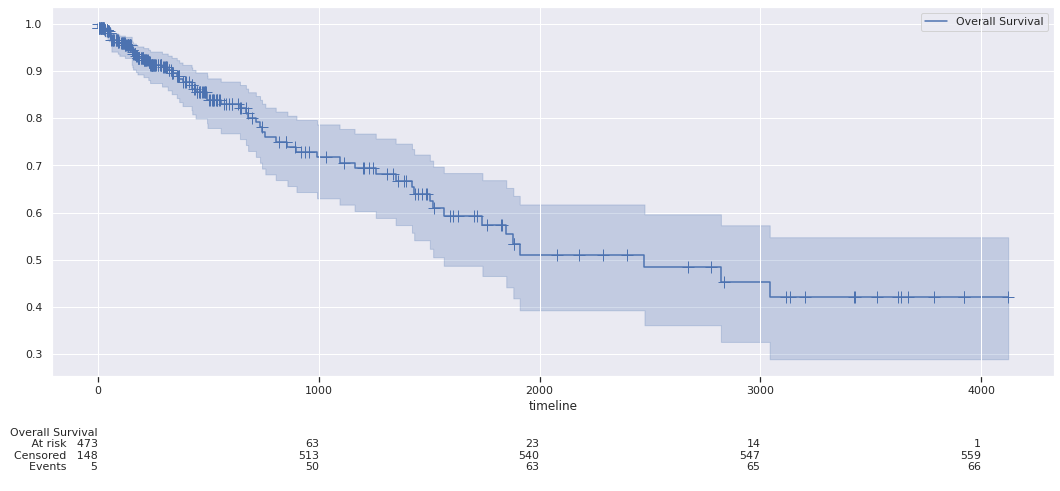

In [9]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

Read the cBioPortal dataset's mRNA (Seq V2), Linear CNA and Methylation (hm450) datasets.

In [10]:
cnv = pd.read_csv(os.path.join(data_directory, 'cnv.csv'), index_col=0)
gex = pd.read_csv(os.path.join(data_directory, 'gex.csv'), index_col=0)
mut = pd.read_csv(os.path.join(data_directory, 'mut.csv'), index_col=0)


cnv.shape, gex.shape, mut.shape

((100, 573), (1000, 573), (200, 573))

Check the maximum RNAseq count value in the dataset.

In [11]:
gex.max().max()

123568.560354

In [12]:
gex_tcga = maui_scale(gex.loc[:,gex.columns.str.contains('TCGA')])
gex_ccle = maui_scale(gex.loc[:,~gex.columns.str.contains('TCGA')])

gex = pd.concat([gex_tcga, gex_ccle], axis=1)
gex = maui_scale(gex)
gex.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,-0.089120,-0.088563,-0.088906,-0.089667,-0.088973,-0.083947,-0.089080,-0.088551,-0.089372,-0.087775,...,-0.533138,2.542210,-0.787012,-0.609028,-0.330970,0.156823,0.344240,0.053214,0.763240,1.470719
ENSG00000211895,-0.523424,-0.202332,0.570615,-0.413167,-0.397846,-0.507563,-0.478897,12.480840,0.453555,0.285514,...,-0.491682,-0.512073,-0.376185,1.310930,-0.512073,-0.117894,-0.380050,-0.487817,-0.351135,-0.512073
ENSG00000034510,-0.033693,-0.404153,-0.453233,-0.099766,-0.244176,0.139135,-0.637896,1.407156,-1.066801,0.485294,...,-0.258449,-0.229124,-0.663397,-0.916127,0.670186,-0.638025,-1.157067,-0.657820,0.137436,-0.475331
ENSG00000087086,8.178617,-1.318908,-0.841834,-0.396125,0.277463,-0.438901,-0.522082,-0.993424,-1.322327,0.556441,...,-0.653667,-1.081281,4.123571,-0.800612,-0.409376,-0.445570,0.136440,0.135698,1.448641,2.778090
ENSG00000102837,-0.511785,-0.490640,-0.159594,-0.284401,-0.433786,-0.518334,2.243403,-0.400271,-0.453776,-0.463837,...,-0.158675,-0.161104,-0.161094,-0.161145,7.250145,-0.148832,-0.161213,-0.161194,-0.159373,-0.161196


Get the datasets that will be used as features:

In [13]:
clinical_patients = set(survival.index)
gex_patients = set(gex.T.index)
cnv_patients = set(cnv.T.index)
mut_patients = set(mut.T.index)

all_sets = [clinical_patients, gex_patients, cnv_patients, mut_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [14]:
df_clin = survival.loc[patients_on_all_datasets]
df_gex = gex.T.loc[patients_on_all_datasets]
df_cnv = cnv.T.loc[patients_on_all_datasets]
df_mut = mut.T.loc[patients_on_all_datasets]
feature_dfs = [df_gex, df_cnv, df_mut]

In [15]:
set(df_cnv.columns) & set(df_mut.columns)

{'PTPRT'}

In [16]:
df_cnv.columns = map(lambda x: x+"_cnv", df_cnv)

In [17]:
set(df_cnv.columns) & set(df_mut.columns)

set()

Get the input dataset:

In [18]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X = scale(df_ae)
X = df_ae.values
durations = df_clin["duration"].values
events = df_clin["observed"].values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


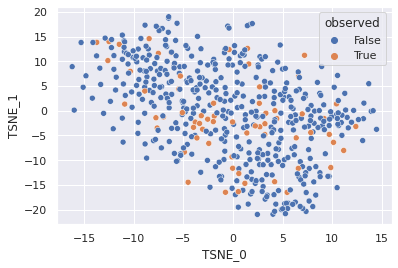

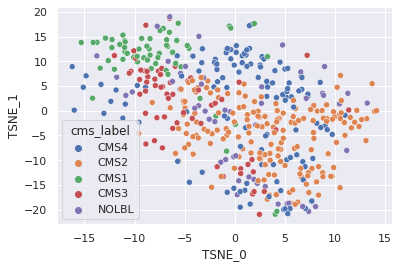

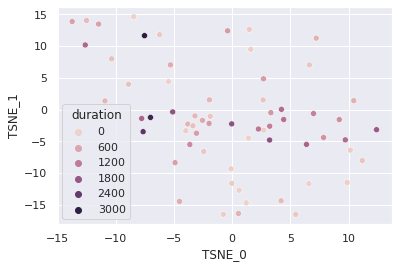

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-AF-4110,3.844606,-10.897584,441,False,1,77.504110,4.0,CMS4
TCGA-G4-6306,12.166412,0.076593,1359,False,1,71.679452,2.0,CMS2
TCGA-RU-A8FL,-8.715445,-9.576156,921,False,1,51.986301,3.0,NaN
TCGA-DC-6158,5.416795,5.644041,212,False,1,70.800000,1.0,CMS4
TCGA-AA-A01T,7.380677,-16.551435,31,False,0,63.539726,3.0,CMS2
...,...,...,...,...,...,...,...,...
TCGA-A6-A567,-0.046819,-2.262331,1881,True,1,56.145205,4.0,CMS2
TCGA-AG-4021,-15.117998,4.767711,0,False,0,84.972603,4.0,CMS4
TCGA-D5-6531,4.760721,13.313497,17,False,1,75.706849,2.0,NOLBL
TCGA-AG-A032,7.274816,-13.181040,31,False,1,68.123288,3.0,CMS2


In [19]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
df_plot

## Train the model

2022-02-07 08:58:31.975142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-07 08:58:31.975165: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-07 08:58:31.975184: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phca-kcl-lat): /proc/driver/nvidia/version does not exist
2022-02-07 08:58:31.977264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/

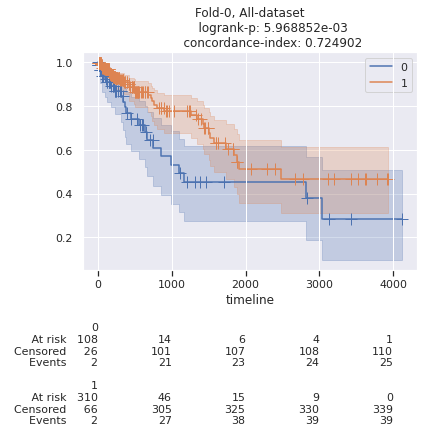

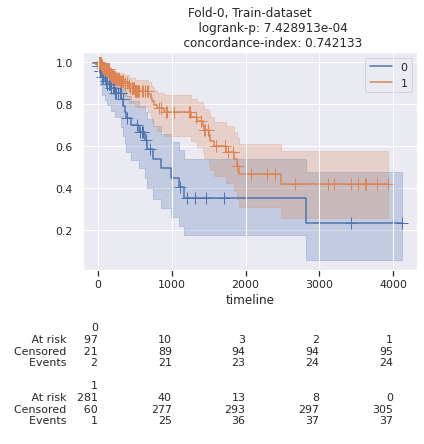

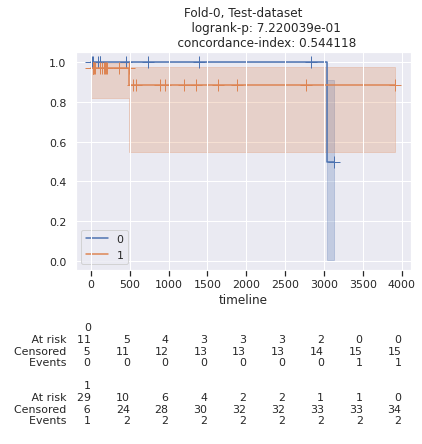

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


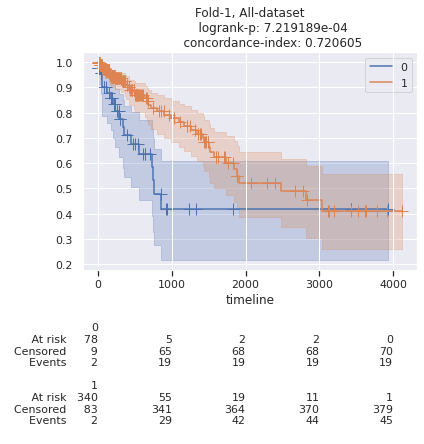

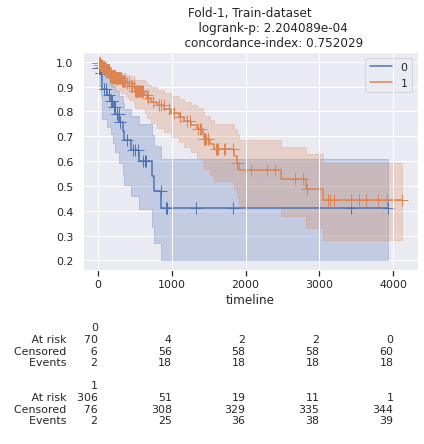

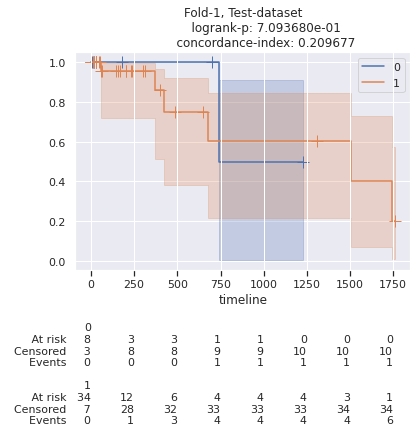

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


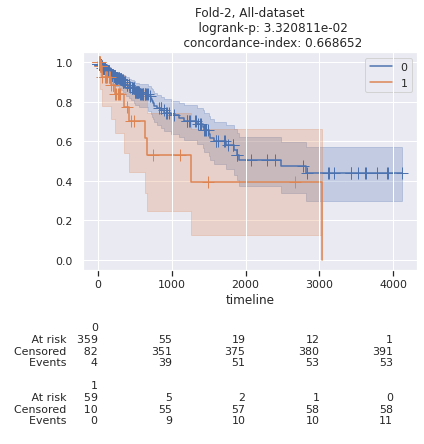

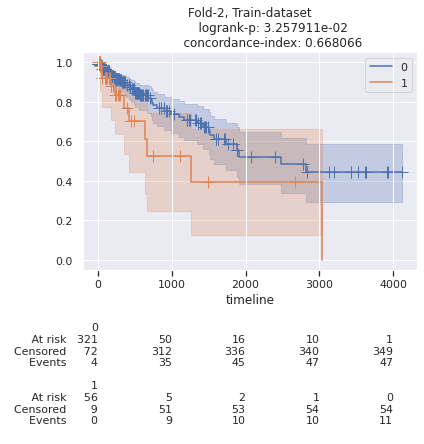

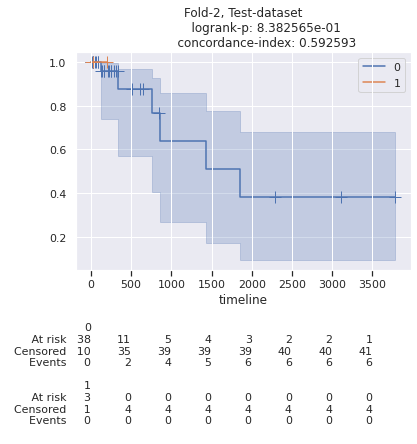

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


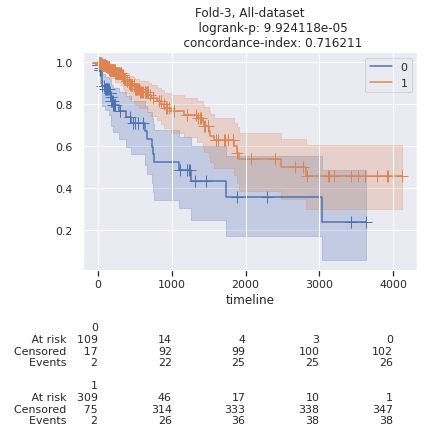

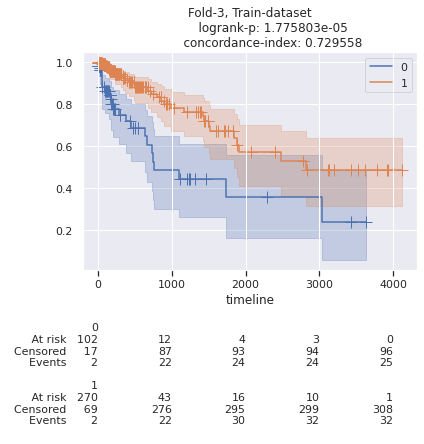

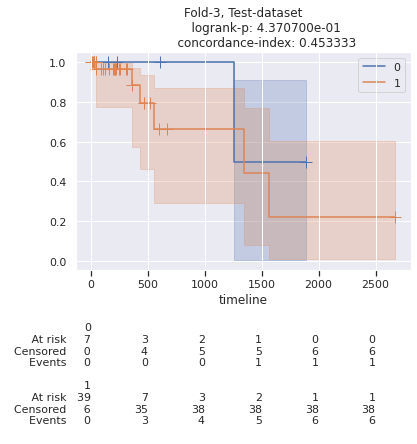

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


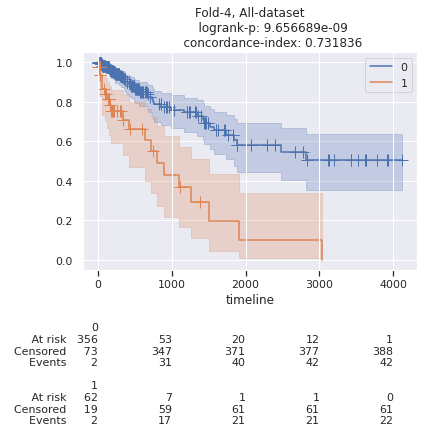

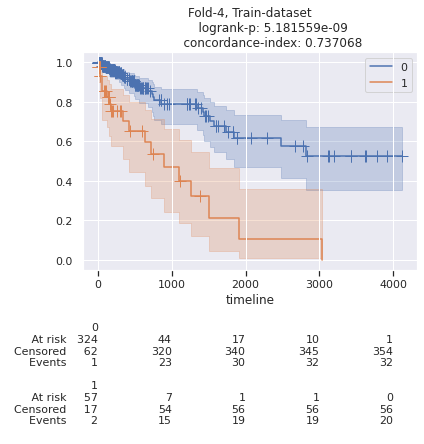

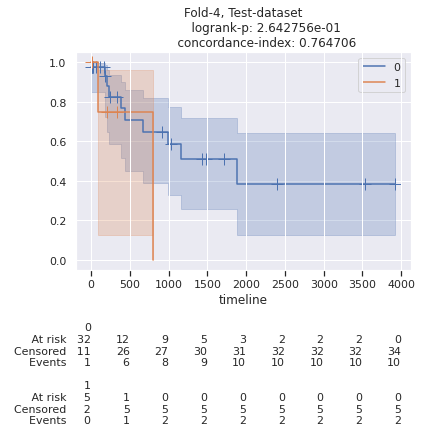

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


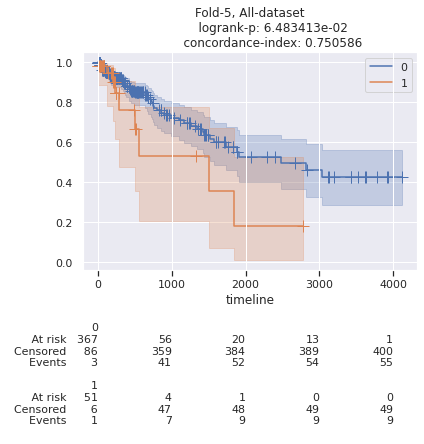

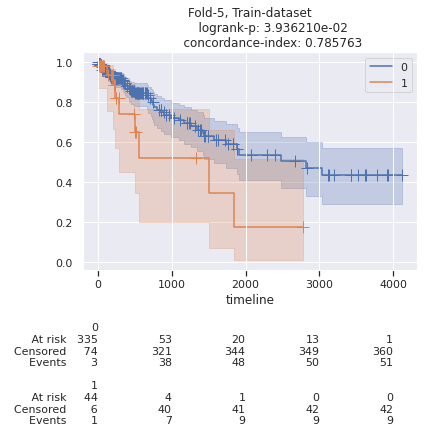

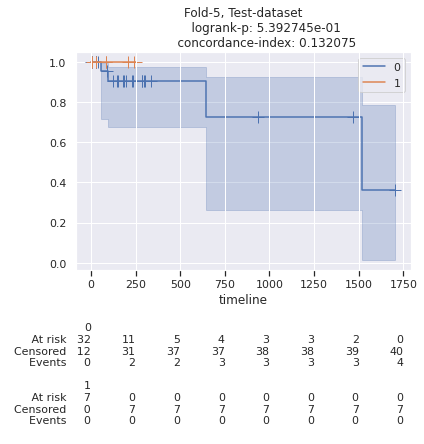

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


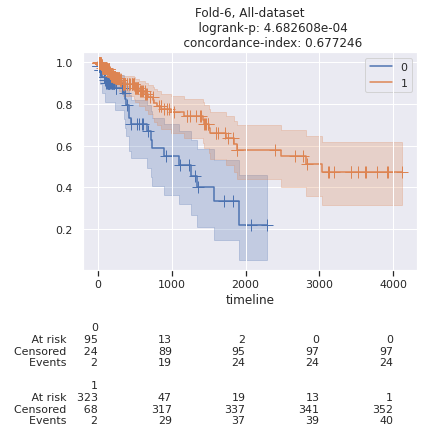

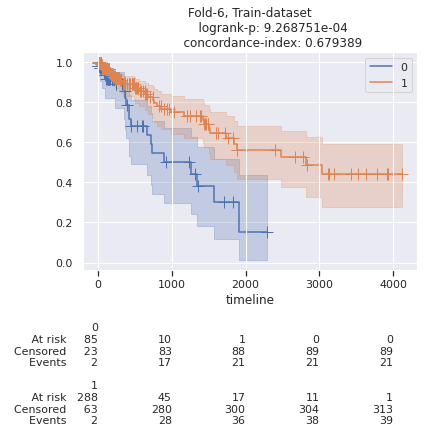

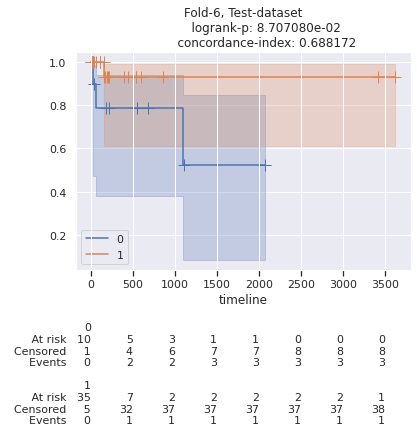

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


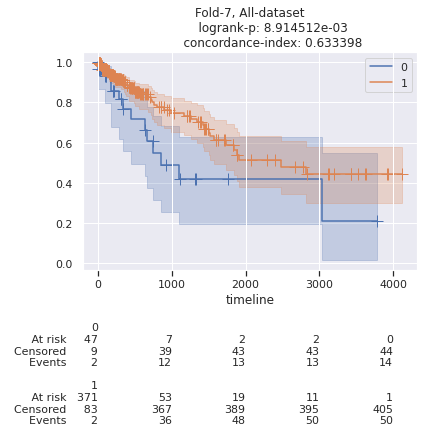

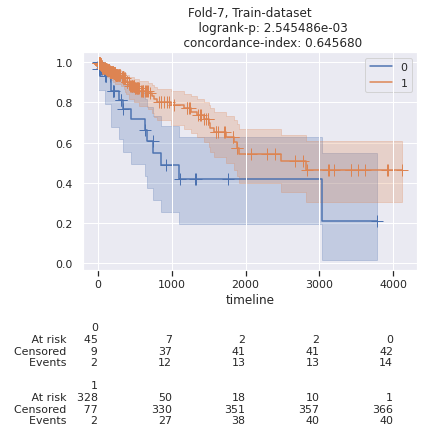

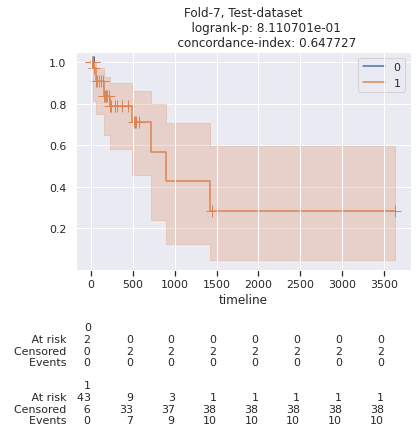

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


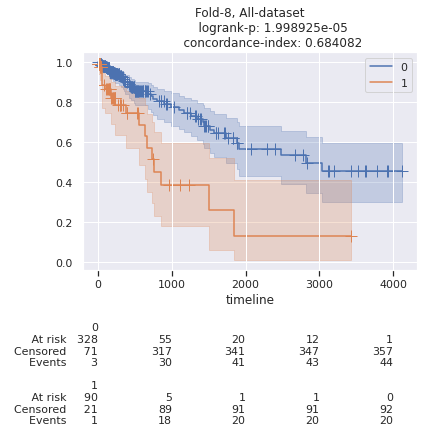

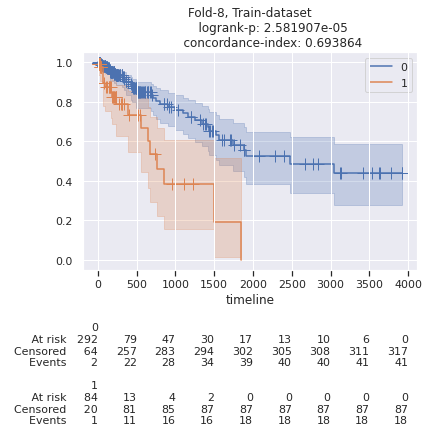

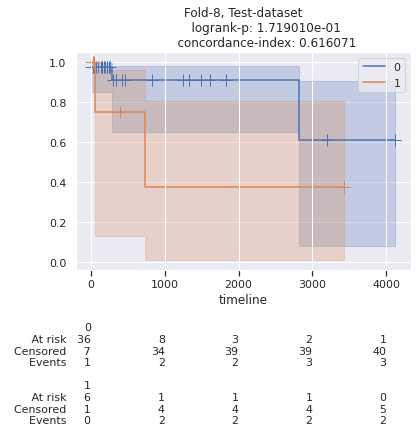

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


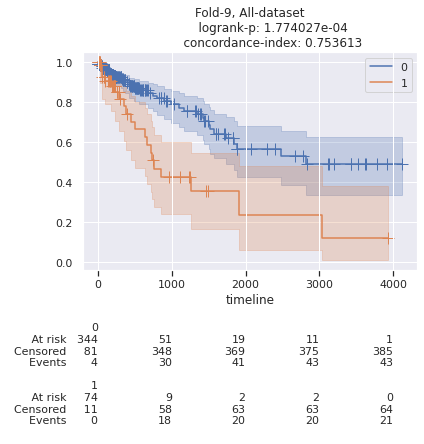

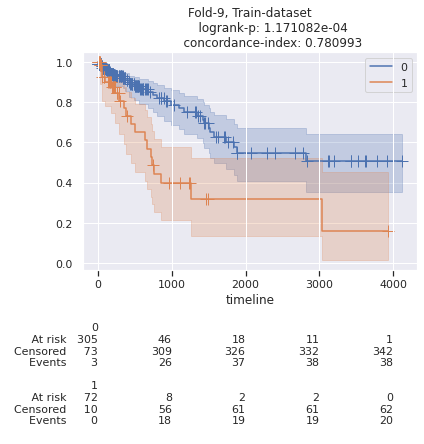

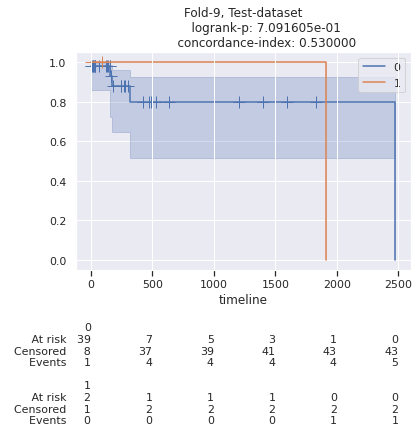

In [20]:
layer_names = ["gex", "cnv", "mut"]
column_names = [df.columns for df in feature_dfs]
cum_n_cols = np.cumsum([len(c) for c in column_names]).tolist()
mapping_n_cols = zip([0] + cum_n_cols[:-1], cum_n_cols)

maui_mappings = {
    layer: lambda x: pd.DataFrame(x[:,s:e].T, index=columns, columns=range(x.shape[0]))
    for layer, columns, (s,e) in zip(
        layer_names,
        column_names,
        mapping_n_cols
    )
}

n_splits = 10
fold_results = []
for fold, (train_index, test_index) in enumerate(KFold(n_splits=n_splits, shuffle=True, random_state=0).split(X)):
    model = MauiClustering(maui_omics_layer_mappings=maui_mappings)
    model.fit(X[train_index], durations[train_index], events[train_index])
    clusters = model.predict(X)
    hazards = model.calculate_hazard(X)

    results = {}
    for name, indexes in zip(["All", "Train", "Test"], [np.concatenate([train_index, test_index]), train_index, test_index]):
        _, p_value = model.logrank_p_score(clusters[indexes], durations[indexes], events[indexes])
        c_index = model.concordance_index(hazards[indexes], durations[indexes], events[indexes])

        plt.figure()#figsize=(15,10))
        ax = plt.gca()
        kmfs, _ = get_kmfs(clusters[indexes], durations[indexes], events[indexes])
        for kmf in kmfs:
            kmf.plot(show_censors=1, ci_show=1, ax=ax)
        lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
        plt.title(
            """Fold-{fold}, {name}-dataset
            logrank-p: {p_value:.6e}
            concordance-index: {c_index:.6f}""".format(
                fold=fold,
                name=name,
                p_value=p_value,
                c_index=c_index,
            )
        )
        plt.show()
        results[name,"p_value"] = p_value
        results[name,"c_index"] = c_index
        results[name,"inv_c_index"] = 1-c_index
        results[name,"asy_c_index"] = abs(1-2*c_index)
    
    fold_results.append(results)

In [21]:
def dropna(x):
    x = np.array(x)
    return x[~np.isnan(x)]

def print_result_table(fold_results, metrics,
        EVALUATION_SETS = ["All", "Train", "Test"],
        AGGREGATION_NAMES = ["mean", "std", "median", "iqr"],
        AGGREGATION_FUNCTIONS = [np.mean, np.std, np.median, lambda x: np.quantile(x,0.75)-np.quantile(x,0.25)],
        float_format = "f"):
    AGGREGATION_NAMES = [f.__name__ for f in AGGREGATION_FUNCTIONS] if AGGREGATION_NAMES is None else AGGREGATION_NAMES
    fold_fmt_str = "Fold-{fold}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    agg_fmt_str = "{agg_name}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    for metric in metrics:
        print("{metric}\tAll\tTrain\tTest".format(metric=metric))
        for fold, results in enumerate(fold_results):
            print(
                fold_fmt_str.format(
                    fold = fold,
                    **{t:results[t,metric] for t in EVALUATION_SETS}
                )
            )
        for agg_name, agg_func in zip(AGGREGATION_NAMES, AGGREGATION_FUNCTIONS):
            aggregated_results = {
                t: agg_func(dropna([r[t,metric] for r in fold_results])) for t in EVALUATION_SETS
            }
            print(agg_fmt_str.format(agg_name=agg_name, **aggregated_results))
        print()

In [22]:
print_result_table(fold_results, ["p_value"], float_format=".6e")

p_value	All	Train	Test
Fold-0	5.968852e-03	7.428913e-04	7.220039e-01
Fold-1	7.219189e-04	2.204089e-04	7.093680e-01
Fold-2	3.320811e-02	3.257911e-02	8.382565e-01
Fold-3	9.924118e-05	1.775803e-05	4.370700e-01
Fold-4	9.656689e-09	5.181559e-09	2.642756e-01
Fold-5	6.483413e-02	3.936210e-02	5.392745e-01
Fold-6	4.682608e-04	9.268751e-04	8.707080e-02
Fold-7	8.914512e-03	2.545486e-03	8.110701e-01
Fold-8	1.998925e-05	2.581907e-05	1.719010e-01
Fold-9	1.774027e-04	1.171082e-04	7.091605e-01
mean	1.144124e-02	7.653756e-03	5.289451e-01
std	2.028078e-02	1.425808e-02	2.605573e-01
median	5.950899e-04	4.816501e-04	6.242175e-01
iqr	8.059316e-03	2.092192e-03	4.113708e-01



In [23]:
print_result_table(fold_results, ["c_index", "asy_c_index"], float_format=".3f")

c_index	All	Train	Test
Fold-0	0.725	0.742	0.544
Fold-1	0.721	0.752	0.210
Fold-2	0.669	0.668	0.593
Fold-3	0.716	0.730	0.453
Fold-4	0.732	0.737	0.765
Fold-5	0.751	0.786	0.132
Fold-6	0.677	0.679	0.688
Fold-7	0.633	0.646	0.648
Fold-8	0.684	0.694	0.616
Fold-9	0.754	0.781	0.530
mean	0.706	0.721	0.518
std	0.037	0.045	0.193
median	0.718	0.733	0.568
iqr	0.051	0.067	0.167

asy_c_index	All	Train	Test
Fold-0	0.450	0.484	0.088
Fold-1	0.441	0.504	0.581
Fold-2	0.337	0.336	0.185
Fold-3	0.432	0.459	0.093
Fold-4	0.464	0.474	0.529
Fold-5	0.501	0.572	0.736
Fold-6	0.354	0.359	0.376
Fold-7	0.267	0.291	0.295
Fold-8	0.368	0.388	0.232
Fold-9	0.507	0.562	0.060
mean	0.412	0.443	0.318
std	0.074	0.090	0.221
median	0.437	0.467	0.264
iqr	0.102	0.133	0.375



(0.0, 1.0)

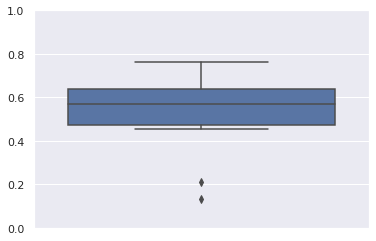

In [24]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

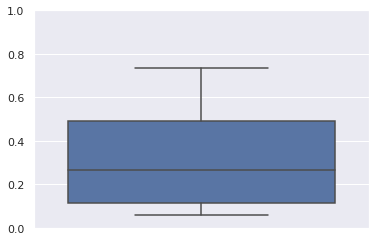

In [25]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

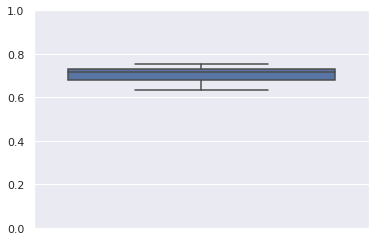

In [26]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

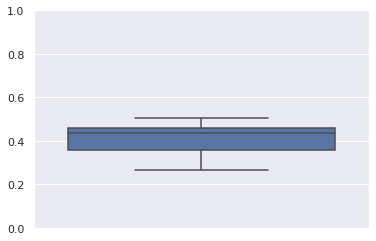

In [27]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

In [28]:
[r["Test","c_index"] for r in fold_results]

[0.5441176470588235,
 0.20967741935483872,
 0.5925925925925926,
 0.4533333333333333,
 0.7647058823529411,
 0.1320754716981132,
 0.6881720430107527,
 0.6477272727272727,
 0.6160714285714286,
 0.53]

In [29]:
[r["All","c_index"] for r in fold_results]

[0.72490234375,
 0.72060546875,
 0.66865234375,
 0.7162109375,
 0.7318359375,
 0.7505859375,
 0.67724609375,
 0.6333984375,
 0.68408203125,
 0.75361328125]

In [30]:
[r["Test","p_value"] for r in fold_results]

[0.722003938857009,
 0.7093679928125661,
 0.8382564863858266,
 0.4370699739211372,
 0.26427561066173477,
 0.5392744732951991,
 0.08707080475126976,
 0.8110701293339088,
 0.17190101088747384,
 0.7091605490915442]

In [31]:
[r["All","p_value"] for r in fold_results]

[0.005968851627528178,
 0.0007219189144154569,
 0.03320810963547436,
 9.924118483607641e-05,
 9.656688704973812e-09,
 0.06483412622066582,
 0.0004682608143484052,
 0.008914512280507785,
 1.9989250855879524e-05,
 0.0001774026558999616]